# **AML Mini Project - food sentiment analysis**

## PF 16 - Mandar Kulkarni Sr-8
## PE 25 - Kargil Thakur Sr-15
## PF 45 - Aniket Kumar Sr-30
## PB 61 - Madhur Maheshwari Sr-46

Data Overview : This dataset contains all the reviews written by people who purchaged iffrent food product from the amazon along with their rating and review


Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

- Id
- ProductId - unique identifier for the product
- UserId - unqiue identifier for the user
- ProfileName
- HelpfulnessNumerator - number of users who found the review helpful
- HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
- Score - rating between 1 and 5
- Time - timestamp for the review
- Summary - brief summary of the review
- Text - text of the review

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is ignored as it can be positive or negative and that can impact our model accuracy. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [65]:
!pip install bs4

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [66]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
import sqlite3
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nltk
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.cm as cm
import numpy as np
import collections
%matplotlib inline
from tqdm import tqdm
import os
from sklearn.metrics import plot_confusion_matrix

Loding Dataset
The dataset is in 2 format

Sqlite Database
.csv file
We will be using Sqlite database as it is more easier to fetch,visulize and do manipulation of data with sql commands

In [67]:
con=sqlite3.connect('/kaggle/input/amazon-fine-food-reviews/database.sqlite')

In [68]:
data=pd.read_sql_query("""
SELECT * 
From reviews
where Score !=3
""",con)
data.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


# [1] Exploratory Data Analysis
Summarry and text are the 2 most important columns that will help us to find if review is positive or negative
So lets merge them together to make thing easy to work

In [69]:
data['total']=data['Summary']+' '+data['Text']
data.total.head(4)

0    Good Quality Dog Food I have bought several of...
1    Not as Advertised Product arrived labeled as J...
2    "Delight" says it all This is a confection tha...
3    Cough Medicine If you are looking for the secr...
Name: total, dtype: object

Plotting Ratings



<AxesSubplot:>

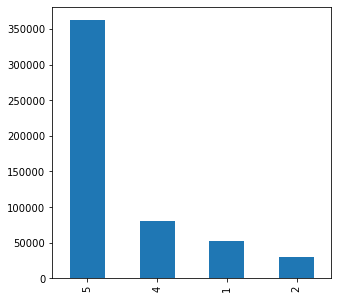

In [70]:
rcParams["figure.figsize"] = 5,5
data["Score"].value_counts()[:4].plot(kind="bar")

# Converting Score into positive or negative
We are going to change our score in the form of positive and negative
Score 1-2 : Negative (0)
Score 4-5 : Positive (1)
Score 3 : Already Neglected

In [71]:
## Writting function to convert score into Positive or Negative
## Positive -> 1 and Negative -> 0
def convert(x):
  if x >3:
    return 1
  return 0

In [72]:
score=data.Score
new=score.map(convert)
#new column after geting score converted in Positive or Negative
# Updating our score  column with  0 & 1 \\ the new colum that we have ceated
data.Score=new

Plot to see our score distribution

<AxesSubplot:ylabel='Score'>

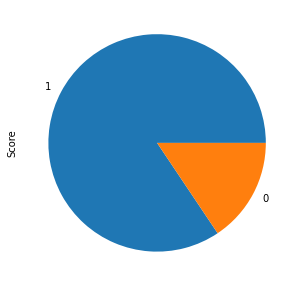

In [73]:
rcParams["figure.figsize"] = 5,5
data["Score"].value_counts().plot(kind="pie")


Here we can see the number of positive reviews are much heigher than that of Negative Reviews

# Data Cleaning (Deduplication)
After having look into data we discovered that there were many duplicacy in data like
Same Person reviewed many product with same time stamp and given similar review and rating.
So it is very important to remove those type of duplicate data in order to prevent unbiased results for the analysis of the data.

Lets have look at some duplications

In [74]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...



Here we can see that same person have reviewdor rated many diffrent product(with diffrent product id at the same timestamp with same review and same rating which is imposible as no once can give review to diffrent products at the same time.Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [75]:
sort_data=data.sort_values(by=['ProductId'],axis=0,ascending =True)
clean=data.drop_duplicates(subset={'ProductId','UserId','ProfileName','Score','Time','Summary'},keep='first',inplace=False)

Checking Total Data Lose

In [76]:
print("Before Cleaning: ",data.shape)
print("After Cleaning: ",clean.shape)
print("Data Lost :",data.shape[0]-clean.shape[0])

Before Cleaning:  (525814, 11)
After Cleaning:  (524507, 11)
Data Lost : 1307


In [77]:

display=pd.read_sql_query('''
Select * 
from Reviews
where Score !=3 and HelpfulnessDenominator < HelpfulnessNumerator ''',con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


**Observation**:- As we know that the HelpfulnessNumerator is the number of users who found the review helpful and HelpfulnessDenominator is number of users who indicated whether they found the review helpful or not
So here we can conclude that HelpfulnessDenominator should always be greater than the HelpfulnessNumerator

In [78]:
# Removing data that violate this
final=clean[clean.HelpfulnessDenominator>=clean.HelpfulnessNumerator]

In [79]:
text=final.total


Checking Null Values



In [80]:
final.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
total                     0
dtype: int64


# [2]Text pre-processing

Preprocessing Review Text
Now when we have finally removed all the duplicates and all unwanted data now we need to do some pre-processing of our data before creating our model

Lets first check out what type of garbage are there in our text
We re going to see the text of random text columm to have a look at our text data garbage

In [81]:
import random
i=0
while i <5:
    
    ran=random.randint(1,1000)
    print("Found at: ",ran)
    print(text.values[ran])
    print('-'*100)
    i+=1

Found at:  430
One bite and you'll become a "chippoisseur" I'm addicted to salty and tangy flavors, so when I opened my first bag of Sea Salt & Vinegar Kettle Brand chips I knew I had a perfect complement to my vegetable trays of cucumber, carrot, celery and cherry tomatoes. Skip the dip; balance the tangy chips by alternating bites of raw vegetable.<br /><br />As an Oregonian, I'm proud to share these delectable snacks with friends, especially those living outside our state and who haven't experienced gourmet chips. I tell them Kettle Brand does for potato chips what microbrews did for beer.<br /><br />Kettle Brand potato chips are unmistakable--a light gold color, rich flavor and amazing crunch. Kettle Brand chips are also a healthier snacking option than the major chip brands. Kettle Brand chips don't have trans fats, MSG or artificial flavors and colorings. The company also has a line of organic potato chips and all of their products are certified Kosher.<br /><br />I also recommen

Here we can see that some of our text have HTML tag within it
So lets remove all the html tags using simple regualr expression
We also have to remove special charater and numbers

In [82]:
## function to remove URl
def removeUrl(text):
  pr=re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  return pr

Now we need to de concatinate words like:
won't -> will not
there're -> there are

In [83]:

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Stop Words Removal And Stemming

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.
Why to remove stopwords?
Removing stopwords can potentially help improve the performance as there are fewer and only meaningful tokens left.
Stemming -> Its the process of reducing inflected words to their word stem, base or root form—generally a written word form

In [84]:

from nltk.stem import SnowballStemmer
snow=nltk.stem.SnowballStemmer('english')

In [85]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [86]:
def removeStopWord(word):
  token=word.split(" ")   ## coverting string to token (list of word) \\ like ["this","is","token"]
  removestop=[snow.stem(x) for x in token if x not in stopwords]   ##removing stopwords and also doing Stemming
  removed=" ".join(removestop)  ##joing back the list into sentence
  return removed

Now lets just create a list containg all cleaned text after applying all the filter that we have discussed



In [87]:
from tqdm import tqdm
preprocessed_reviews = []
for line in tqdm(final.total.values):
  line= BeautifulSoup(line, 'lxml').get_text() ## Remove Html Tags
  line=removeUrl(line) #removing url
  line=decontracted(line)    #Coverting word like { are't -> are not}
  line = re.sub(r'[0-9]+', '', line)   ## To Remove Numbers from the string
  line=line.lower()   ## Converting every word to lower case
  line = re.sub(r'[^a-z0-9\s]', '', line)   ## To clean all special Charaters
  line=removeStopWord(line)    ## Removing Stop Words And doing Steaming
  preprocessed_reviews.append(line.strip()) ## ading cleaned word into a list after removing spaces {By using strip()}

100%|██████████| 524505/524505 [09:19<00:00, 938.06it/s] 


# [4]Featurization
## Tf-Idf and by-grams¶

In [88]:
#tfidf
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(max_features=5000,ngram_range=(1, 2))
counts = count_vectorizer.fit_transform(preprocessed_reviews)
tfidf = transformer.fit_transform(counts)

# Modeling

In [89]:
y=np.array(final['Score'])

In [90]:
#split in samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf,y,test_size=0.3, random_state=0)

# Using LogisticRegression


In [91]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)

logreg.fit(X_train, y_train)
print('Accuracy of Lasso classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Lasso classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Lasso classifier on training set: 0.96
Accuracy of Lasso classifier on test set: 0.95


In [92]:

predictions = logreg.predict(X_test)
print('AUC: ', roc_auc_score(y_test, predictions))
cm= confusion_matrix(y_test,predictions)

AUC:  0.896202715722878


# Accuracy --> 93%

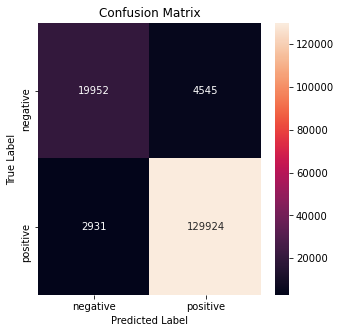

In [93]:
conf_mat = confusion_matrix(y_test, predictions)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()